# Multimodal Sentiment Analysis with Transformer Model
This notebook demonstrates a multimodal sentiment analysis approach using RoBERTa for text encoding, DenseNet for image encoding, and a Transformer model for feature fusion. The goal is to classify tweets based on text and images into sentiment categories: "Certainly Fake," "Probably Fake," "Probably Real," and "Certainly Real." Key metrics tracked include accuracy, F1-score, and loss over training epochs, with the best-performing models saved.



# Setup and Imports
We start by importing the necessary libraries, setting up CUDA for GPU debugging, and initializing device settings.


In [1]:
!pip install torch-geometric
# Enable CUDA debugging if available
%env CUDA_LAUNCH_BLOCKING=1

import os
import shutil
import torch
import torch.nn as nn
import pandas as pd
from transformers import RobertaTokenizer, RobertaModel
from torchvision import models, transforms
from torch_geometric.loader import DataLoader
from PIL import Image
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.4 MB/s eta 0:00:00
env: CUDA_LAUNCH_BLOCKING=1


# Dataset Loading and Preprocessing
We load the dataset and preprocess it to filter out errors and missing values.

In [ ]:
# Load dataset
data = pd.read_csv("Multimodal-Sentiment-Classification\Updated_Tweet_Data.csv")
# Filter out invalid entries
data = data[data['Content'] != "Error: Tweet could not be scraped"]
data = data.dropna(subset=['Image_Name']).reset_index(drop=True)

# Dataset EDA
Here we try to find out our distribution of our data

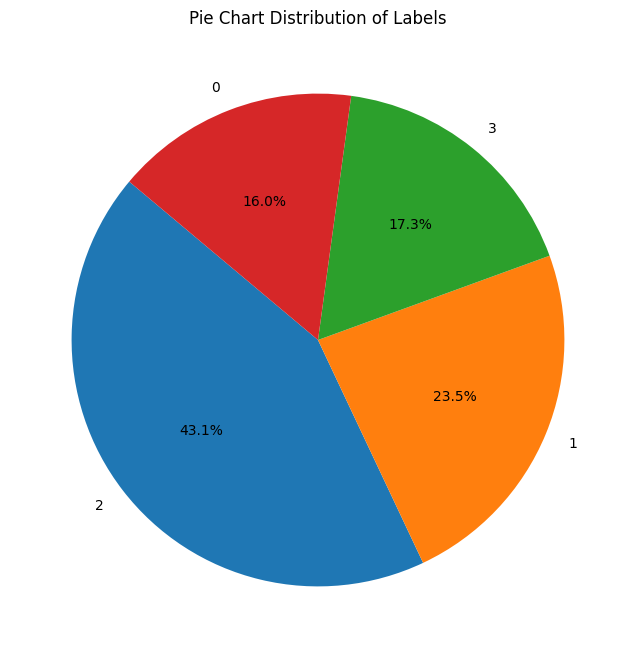

Label
2    207
1    113
3     83
0     77
Name: count, dtype: int64


In [3]:
import matplotlib.pyplot as plt
df = data
label_counts = df['Label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Pie Chart Distribution of Labels")
plt.show()
print(data.Label.value_counts())

1. **Text Preprocessing**

    We tokenize text data using the RoBERTa tokenizer with padding and truncation for consistent input size.


In [4]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def preprocess_text(text):
    encoding = tokenizer(text, padding="max_length", max_length=128, truncation=True, return_tensors="pt")
    return encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


2. **Image Preprocessing**
    
   Image transformations include resizing, normalization, and random augmentations to improve model generalization.



In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_name):
    if pd.isna(image_name) or not isinstance(image_name, str):
        return torch.zeros(3, 224, 224)
    image_path = os.path.join("Multimodal-Sentiment-Classification\\Tweet_Image\\", image_name)
    try:
        image = Image.open(image_path).convert("RGB")
        return image_transform(image)
    except FileNotFoundError:
        print(f"Warning: Image file '{image_path}' not found. Using placeholder.")
        return torch.zeros(3, 224, 224)

# Model Architecture

1. **Text Encoder (RoBERTa)**
    
    The text encoder uses a RoBERTa model with a dropout layer. We initially freeze RoBERTa layers for faster training.

In [6]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        for param in self.roberta.parameters():
            param.requires_grad = False  # Freeze RoBERTa
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return self.dropout(outputs.pooler_output)

2. **Image Encoder (DenseNet-121)**

    The image encoder is built on a pre-trained DenseNet model, extracting image features with dropout for regularization.

In [7]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.densenet = nn.Sequential(*list(densenet.features.children()))
        for param in self.densenet.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, images):
        features = self.densenet(images)
        features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
        return self.dropout(features.view(features.size(0), -1))

3. **Multimodal Transformer Model**
    
    This model fuses text and image features via a Transformer encoder for classification.

In [8]:
class MultimodalTransformerModel(nn.Module):
    def __init__(self, text_dim=768, image_dim=1024, hidden_dim=512, output_dim=4):
        super(MultimodalTransformerModel, self).__init__()
        self.text_projection = nn.Linear(text_dim, hidden_dim)
        self.image_projection = nn.Linear(image_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text_features, image_features):
        batch_size = text_features.size(0)
        text_features = self.text_projection(text_features)
        image_features = self.image_projection(image_features)
        combined_features = torch.cat([text_features.unsqueeze(1), image_features.unsqueeze(1)], dim=1)
        fused_features = self.transformer_encoder(combined_features).mean(dim=1)
        return self.classifier(fused_features)

# Dataset and Dataloader with Custom Collate Function
   We create a custom dataset class and collate function to handle dynamic padding for text input.


In [9]:
class EvalitaDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text_input, attention_mask = preprocess_text(row["Content"])
        image_input = preprocess_image(row["Image_Name"])
        label = torch.tensor(row["Label"], dtype=torch.long)
        return {'input_ids': text_input, 'attention_mask': attention_mask, 'pixel_values': image_input}, label
    
    def __len__(self):
        return len(self.data)

def collate_fn(batch):
    inputs, labels = zip(*batch)
    pixel_values = torch.stack([item['pixel_values'] for item in inputs])
    input_ids = pad_sequence([item['input_ids'] for item in inputs], batch_first=True)
    attention_mask = pad_sequence([item['attention_mask'] for item in inputs], batch_first=True)
    labels = torch.stack(labels)
    return {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask}, labels

dataset = EvalitaDataset(data)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Training Loop and Model-Saving Logic
In this training loop, we track and save the models with the highest accuracy and F1-score across epochs.

In [10]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# Initialize Models, Optimizer, and Loss
text_encoder = TextEncoder().to(device)
image_encoder = ImageEncoder().to(device)
model = MultimodalTransformerModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

import os
import shutil
import torch
import torch.nn as nn
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Directories to save the best models
highest_acc_dir = "/kaggle/working/highest_acc"
highest_f1_dir = "/kaggle/working/highest_f1"
os.makedirs(highest_acc_dir, exist_ok=True)
os.makedirs(highest_f1_dir, exist_ok=True)

# Initialize tracking variables for highest metrics
best_accuracy = 0.0
best_f1_score = 0.0

# Training loop with model-saving logic
history = {'epoch': [], 'loss': [], 'accuracy': [], 'f1_score': []}
for epoch in range(100):  # Adjust epochs as needed
    model.train()
    total_loss, correct_predictions, total_samples = 0, 0, 0
    all_preds, all_labels = [], []
    
    for batch in dataloader:
        inputs, labels = batch
        input_ids, attention_mask, pixel_values = [inputs[key].to(device) for key in ['input_ids', 'attention_mask', 'pixel_values']]
        labels = labels.to(device)
        
        text_features = text_encoder(input_ids, attention_mask)
        image_features = image_encoder(pixel_values)
        
        outputs = model(text_features, image_features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    f1 = f1_score(all_labels, all_preds, average="weighted")
    
    scheduler.step(f1)
    
    # Save to history
    history['epoch'].append(epoch + 1)
    history['loss'].append(avg_loss)
    history['accuracy'].append(accuracy)
    history['f1_score'].append(f1)
    
    # Check for new highest accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        shutil.rmtree(highest_acc_dir)
        os.makedirs(highest_acc_dir, exist_ok=True)
        torch.save({
            'text_encoder_state_dict': text_encoder.state_dict(),
            'image_encoder_state_dict': image_encoder.state_dict(),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }, os.path.join(highest_acc_dir, "best_accuracy_model.pth"))
        print(f"New best accuracy model saved with accuracy: {best_accuracy:.4f}")

    # Check for new highest F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        shutil.rmtree(highest_f1_dir)
        os.makedirs(highest_f1_dir, exist_ok=True)
        torch.save({
            'text_encoder_state_dict': text_encoder.state_dict(),
            'image_encoder_state_dict': image_encoder.state_dict(),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }, os.path.join(highest_f1_dir, "best_f1_model.pth"))
        print(f"New best F1 score model saved with F1 score: {best_f1_score:.4f}")
    
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | F1 Score: {f1:.4f}")

Using device: cuda


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /

New best accuracy model saved with accuracy: 0.3917
New best F1 score model saved with F1 score: 0.2682
Epoch 1 | Loss: 1.3553 | Accuracy: 0.3917 | F1 Score: 0.2682
New best accuracy model saved with accuracy: 0.4125
New best F1 score model saved with F1 score: 0.2859
Epoch 2 | Loss: 1.3372 | Accuracy: 0.4125 | F1 Score: 0.2859
New best accuracy model saved with accuracy: 0.4146
Epoch 3 | Loss: 1.3248 | Accuracy: 0.4146 | F1 Score: 0.2679
New best accuracy model saved with accuracy: 0.4292
Epoch 4 | Loss: 1.2941 | Accuracy: 0.4292 | F1 Score: 0.2679
Epoch 5 | Loss: 1.2833 | Accuracy: 0.4167 | F1 Score: 0.2812
New best accuracy model saved with accuracy: 0.4417
New best F1 score model saved with F1 score: 0.3043
Epoch 6 | Loss: 1.2874 | Accuracy: 0.4417 | F1 Score: 0.3043
New best F1 score model saved with F1 score: 0.3245
Epoch 7 | Loss: 1.2758 | Accuracy: 0.4375 | F1 Score: 0.3245
New best accuracy model saved with accuracy: 0.4437
Epoch 8 | Loss: 1.2433 | Accuracy: 0.4437 | F1 Score:

# Model Performance Analysis
1. This section includes plotting training history, confusion matrix, classification report, and ROC-AUC curves.
2. Visualizations help interpret the model’s performance by class and highlight areas for improvement.


Training History:
    epoch      loss  accuracy  f1_score
0       1  1.355316  0.391667  0.268162
1       2  1.337159  0.412500  0.285908
2       3  1.324803  0.414583  0.267874
3       4  1.294085  0.429167  0.267937
4       5  1.283301  0.416667  0.281229
..    ...       ...       ...       ...
95     96  0.854863  0.679167  0.672187
96     97  0.848275  0.681250  0.673495
97     98  0.828863  0.664583  0.657260
98     99  0.910261  0.635417  0.623530
99    100  0.923842  0.608333  0.597625

[100 rows x 4 columns]


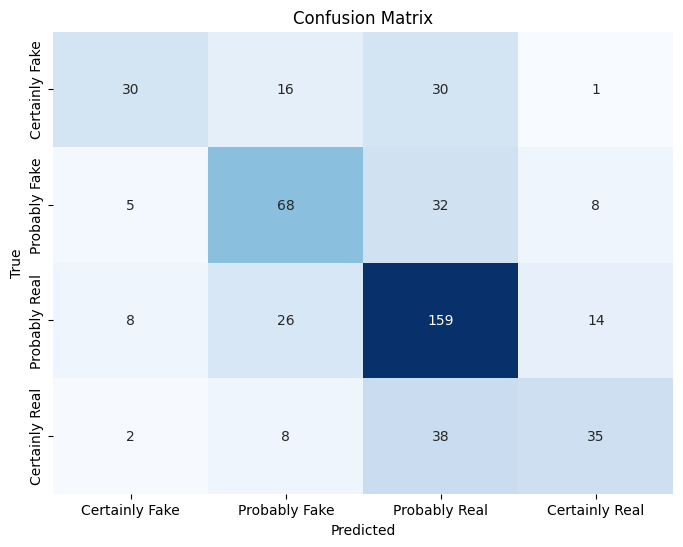


Errors by Class:
                Total Errors
Certainly Real            48
Probably Real             48
Certainly Fake            47
Probably Fake             45

Classification Report:
                precision    recall  f1-score     support
Certainly Fake   0.666667  0.389610  0.491803   77.000000
Probably Fake    0.576271  0.601770  0.588745  113.000000
Probably Real    0.613900  0.768116  0.682403  207.000000
Certainly Real   0.603448  0.421687  0.496454   83.000000
accuracy         0.608333  0.608333  0.608333    0.608333
macro avg        0.615071  0.545296  0.564851  480.000000
weighted avg     0.611699  0.608333  0.597625  480.000000


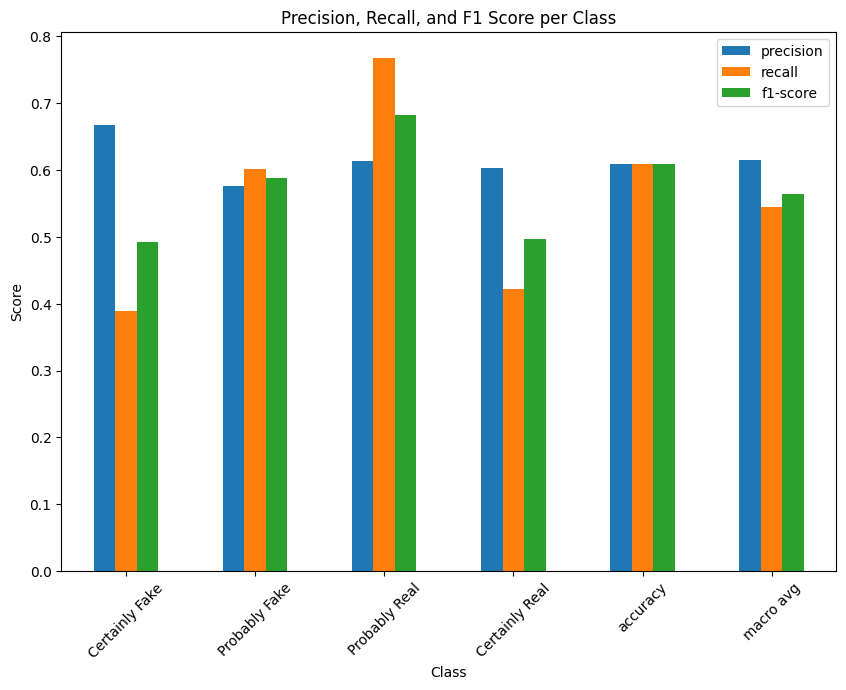

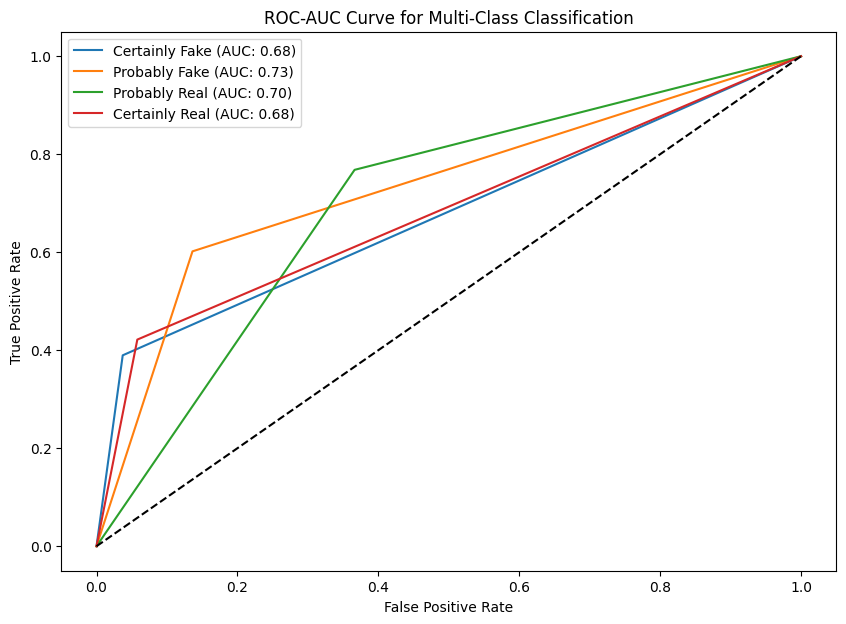

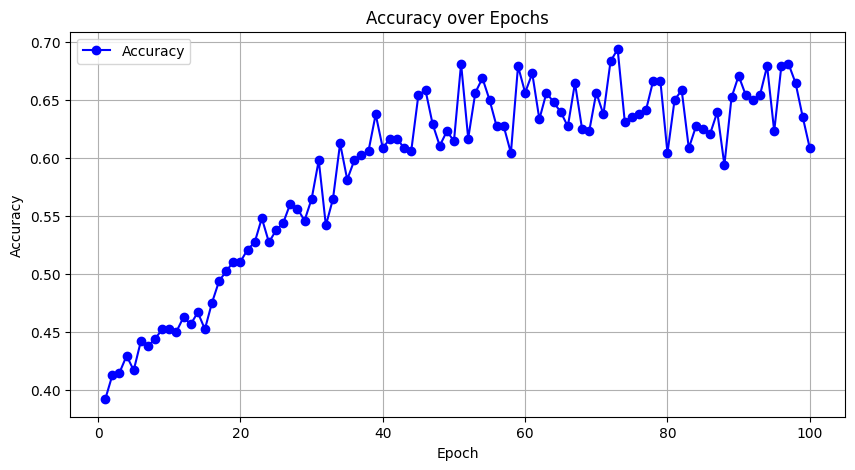

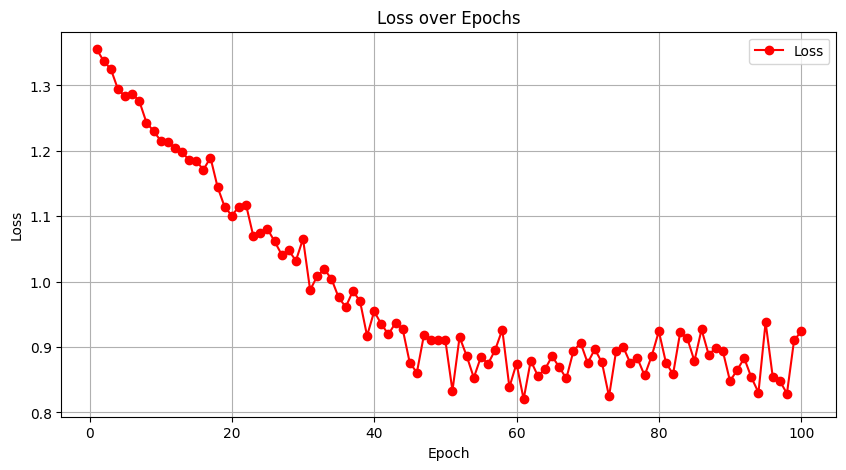

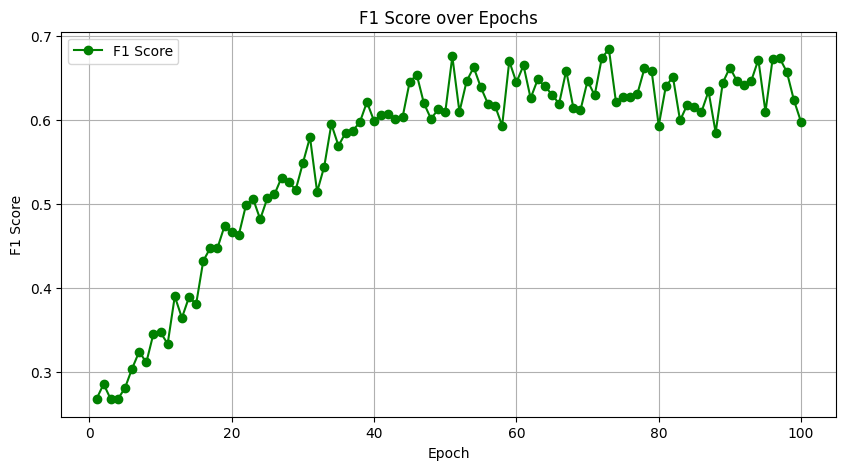

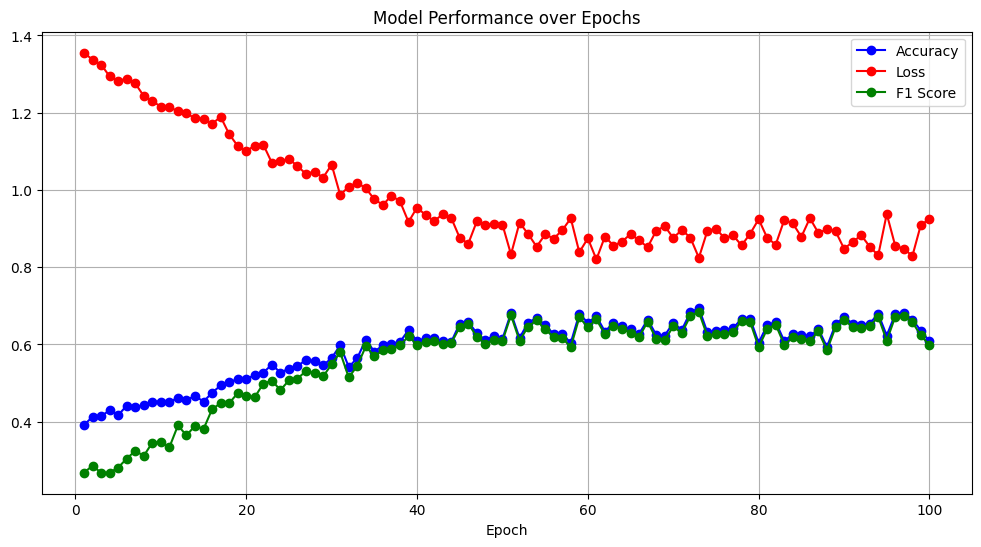

In [11]:
import numpy as np
# EDA: Convert history to DataFrame for analysis
history_df = pd.DataFrame(history)
print("\nTraining History:")
print(history_df)
history_df.to_csv("Training_history.csv", index=False)
# EDA Part - Model Performance Analysis

# 1. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Certainly Fake", "Probably Fake", "Probably Real", "Certainly Real"],
            yticklabels=["Certainly Fake", "Probably Fake", "Probably Real", "Certainly Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Error Analysis by Class
errors = pd.DataFrame(conf_matrix, index=["Certainly Fake", "Probably Fake", "Probably Real", "Certainly Real"],
                      columns=["Certainly Fake", "Probably Fake", "Probably Real", "Certainly Real"])
errors['Total Errors'] = errors.sum(axis=1) - np.diag(errors)
print("\nErrors by Class:")
print(errors[['Total Errors']].sort_values(by='Total Errors', ascending=False))

# 3. Classification Report
report = classification_report(all_labels, all_preds, target_names=["Certainly Fake", "Probably Fake", "Probably Real", "Certainly Real"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(report_df)

# Plot Precision, Recall, and F1 Score per Class
metrics = report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude support and accuracy row
metrics.plot(kind='bar', figsize=(10, 7))
plt.title("Precision, Recall, and F1 Score per Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

# 4. ROC-AUC Curve for Multi-Class Classification
y_true = label_binarize(all_labels, classes=[0, 1, 2, 3])
y_scores = label_binarize(all_preds, classes=[0, 1, 2, 3])

plt.figure(figsize=(10, 7))
for i, class_name in enumerate(["Certainly Fake", "Probably Fake", "Probably Real", "Certainly Real"]):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC: {roc_auc_score(y_true[:, i], y_scores[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Multi-Class Classification")
plt.legend()
plt.show()

import matplotlib.pyplot as plt
import pandas as pd

# Assuming `history` dictionary contains 'epoch', 'loss', 'accuracy', and 'f1_score'
# Convert history to DataFrame for easier plotting
history_df = pd.DataFrame(history)

# Plot Accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.plot(history_df['epoch'], history_df['accuracy'], marker='o', label='Accuracy', color='b')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(history_df['epoch'], history_df['loss'], marker='o', label='Loss', color='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot F1 Score over Epochs
plt.figure(figsize=(10, 5))
plt.plot(history_df['epoch'], history_df['f1_score'], marker='o', label='F1 Score', color='g')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()
plt.grid()
plt.show()

# Combined Plot: Accuracy, Loss, and F1 Score over Epochs
plt.figure(figsize=(12, 6))
plt.plot(history_df['epoch'], history_df['accuracy'], marker='o', label='Accuracy', color='b')
plt.plot(history_df['epoch'], history_df['loss'], marker='o', label='Loss', color='r')
plt.plot(history_df['epoch'], history_df['f1_score'], marker='o', label='F1 Score', color='g')
plt.xlabel("Epoch")
plt.title("Model Performance over Epochs")
plt.legend()
plt.grid()
plt.show()